# Inference Example for Cotatron

This script shows the example usage of pre-trained Cotatron and
voice conversion system trained with them.

---

"Cotatron: Transcription-Guided Speech Encoder for Any-to-Many Voice Conversion without Parallel Data"

- Author: Seung-won Park, Doo-young Kim, Myun-chul Joe @ Seoul National University, MINDsLab Inc.
- Paper: https://arxiv.org/abs/2005.03295 (To appear in INTERSPEECH 2020)
- Audio Samples: https://mindslab-ai.github.io/cotatron
- GitHub: https://github.com/mindslab-ai/cotatron


In [ ]:
# Check GPU being used.
# To use GPU: Runtime > Change runtime type > GPU.
!nvidia-smi

Wed Oct 21 05:28:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/mindslab-ai/cotatron.git .

fatal: destination path '.' already exists and is not an empty directory.


In [ ]:
!pip install omegaconf unidecode pytorch-lightning==0.7.1 pyyaml

## Import requirements

In [ ]:
import os
import gdown
import librosa
import argparse
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.nn.functional as F

os.sys.path.append('./cotatron')
from synthesizer import Synthesizer
from datasets.text import Language

## Download pre-trained weights and config files

The pre-trained decoder file also contains the cotatron by itself.

In [ ]:
gdown.download('https://drive.google.com/uc?id=1ZSfrh8TGVNrqDTSWSizGSpUAcpSV2vuh', 'libritts_vctk_global.yaml', quiet=False)
gdown.download('https://drive.google.com/uc?id=1c-K8ysMkMmLBm2VvcPqJrlefwb8PzBra', 'libritts_vctk_vc.yaml', quiet=False)
gdown.download('https://drive.google.com/uc?id=1slbH0OSUHu7CMWK9aye93yH2JDpE4uZ2', 'pretrained_decoder_libritts_vctk_epoch652_15388cc.ckpt', quiet=False)
gdown.download('https://drive.google.com/uc?id=1sYSFFxL0JFUzP1TdhjuFfOEPByQGryxt', 'melgan_libritts_g_only.ckpt', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZSfrh8TGVNrqDTSWSizGSpUAcpSV2vuh
To: /content/libritts_vctk_global.yaml
100%|██████████| 3.34k/3.34k [00:00<00:00, 2.77MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c-K8ysMkMmLBm2VvcPqJrlefwb8PzBra
To: /content/libritts_vctk_vc.yaml
100%|██████████| 583/583 [00:00<00:00, 171kB/s]
Downloading...
From: https://drive.google.com/uc?id=1slbH0OSUHu7CMWK9aye93yH2JDpE4uZ2
To: /content/pretrained_decoder_libritts_vctk_epoch652_15388cc.ckpt
164MB [00:00, 250MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sYSFFxL0JFUzP1TdhjuFfOEPByQGryxt
To: /content/melgan_libritts_g_only.ckpt
17.1MB [00:00, 132MB/s] 


'melgan_libritts_g_only.ckpt'

In [ ]:
hp_path = ['libritts_vctk_global.yaml', 'libritts_vctk_vc.yaml']
hp_global = OmegaConf.load(hp_path[0])
hp_vc = OmegaConf.load(hp_path[1])
hp = OmegaConf.merge(hp_global, hp_vc)

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--config')
hparams = parser.parse_args(['--config', hp_path])

In [ ]:
checkpoint = torch.load('pretrained_decoder_libritts_vctk_epoch652_15388cc.ckpt', map_location='cpu')

model = Synthesizer(hparams).cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.freeze()

In [ ]:
lang = Language(hp.data.lang, hp.data.text_cleaners)

## Prepare the source speech and its transcription

In [ ]:
# download the first source audio sample from https://mindslab-ai.github.io/cotatron/
!wget https://mindslab-ai.github.io/cotatron/audio/m2m/source_p293_148-22k.wav

--2020-10-21 05:28:56--  https://mindslab-ai.github.io/cotatron/audio/m2m/source_p293_148-22k.wav
Resolving mindslab-ai.github.io (mindslab-ai.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to mindslab-ai.github.io (mindslab-ai.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225864 (221K) [audio/wav]
Saving to: ‘source_p293_148-22k.wav.1’

source_p293_148-22k 100%[===================>] 220.57K  --.-KB/s    in 0.05s   

2020-10-21 05:28:57 (4.15 MB/s) - ‘source_p293_148-22k.wav.1’ saved [225864/225864]



In [ ]:
text = 'sometimes you get them sometimes you dont'
source_wavpath = 'source_p293_148-22k.wav'

In [ ]:
text_norm = torch.LongTensor(lang.text_to_sequence(text, hp.data.text_cleaners))
text_norm = text_norm.unsqueeze(0).cuda()

wav_source_original, sr = librosa.load(source_wavpath, sr=None, mono=True)
wav_source_original *= (0.99 / np.max(np.abs(wav_source_original)))
assert sr == hp.audio.sampling_rate
wav_source = torch.from_numpy(wav_source_original).view(1, 1, -1).cuda()
mel_source = model.cotatron.audio2mel(wav_source)

target_speaker = torch.LongTensor([hp.data.speakers.index('p234')]).cuda()

## Convert (Inference)

In [ ]:
with torch.no_grad():
    mel_s_t, alignment, residual = model.inference(text_norm, mel_source, target_speaker)

In [ ]:
ms = mel_source[0].cpu().detach().numpy()
mst = mel_s_t[0].cpu().detach().numpy()
a = alignment[0].cpu().detach().numpy()
r = residual[0][0].cpu().detach().numpy()

In [ ]:
%matplotlib inline
def show_spectrogram(mel):
    plt.figure(figsize=(15, 4))
    plt.imshow(mel, aspect='auto', origin='lower', interpolation='none')
    plt.xlabel('time frames')
    plt.ylabel('mel')
    plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
    cax = plt.axes([0.9, 0.1, 0.02, 0.8])
    plt.colorbar(cax=cax)
    plt.show()

## Alignment plot
Note that the Cotatron learns text-audio alignment in totally unsupervised manner.

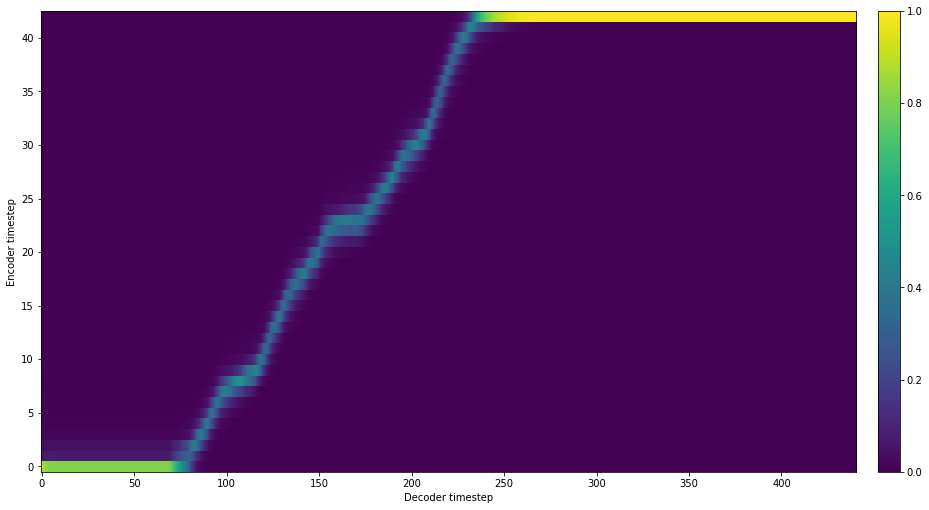

In [ ]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(a.T, aspect='auto', origin='lower', interpolation='none', norm=Normalize(vmin=0.0, vmax=1.0))
plt.xlabel('Decoder timestep')
plt.ylabel('Encoder timestep')
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8])
plt.colorbar(cax=cax)
plt.show()

## Source mel-spectrogram

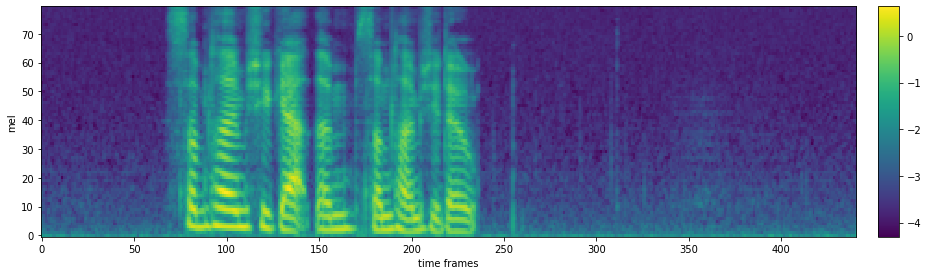

In [ ]:
show_spectrogram(ms)

## Converted mel-spectrogram

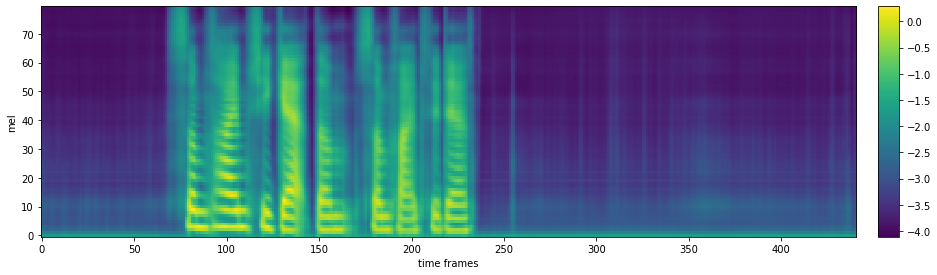

In [ ]:
show_spectrogram(mst)

## Visualization of residual features

average residual value: -0.002


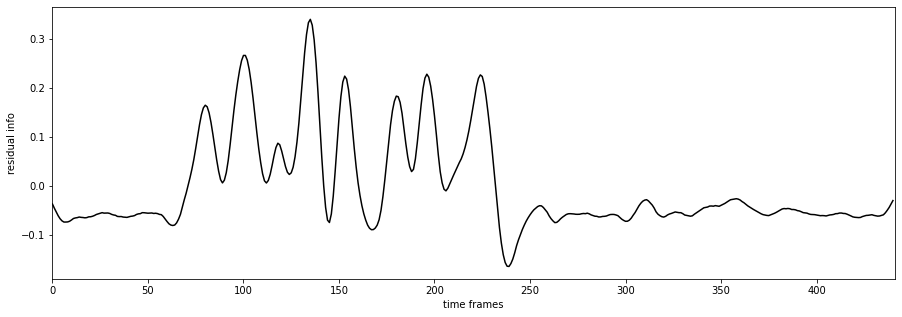

In [ ]:
%matplotlib inline
plt.figure(figsize=(15, 5))
plt.plot(r, color='black')
plt.xlim(0, len(r))
# plt.ylim(-1, 1)
plt.xlabel('time frames')
plt.ylabel('residual info')
plt.subplots_adjust(left=0.1, right=0.88)
print('average residual value: %.3f' % (sum(r) / len(r)))

## Convert mel-spectrogram into raw-audio with MelGAN

As described in our paper, the melgan is pre-trained with whole LibriTTS dataset.

In [ ]:
from melgan.generator import Generator

In [ ]:
melgan = Generator(80).cuda()
melgan_ckpt = torch.load('melgan_libritts_g_only.ckpt', map_location='cpu')
melgan.load_state_dict(melgan_ckpt['model_g'])
melgan.eval()

In [ ]:
with torch.no_grad():
    audio_s_t = melgan(mel_s_t).squeeze().cpu().detach().numpy()

## Finally, the audio samples!

### Source speech

In [ ]:
ipd.Audio(wav_source_original, rate=22050)

### Converted speech
Synthesized with Cotatron-based VC system + MelGAN.

In [ ]:
ipd.Audio(audio_s_t, rate=22050)

## Caveat

The checkpoint that we release via this Jupyter Notebook is different from the one we used for writing our paper. For instance, the decoder was trained for only 7 days with single GPU for now.

Therefore, the results produced with this notebook might differ from the results shown in our paper or the audio samples webpage.